# **Assignment \#3**: Machine Learning MC886/MO444
University of Campinas (UNICAMP), Institute of Computing (IC)

Prof. Sandra Avila, 2022s2



In [ ]:
# TODO: RA & Name
print('RA1: 199624 ' + 'João Guilherme Alves Santos')
print('RA2: 184181 ' + 'Maria Júlia de Lima Silva')

RA1: 199624 João Guilherme Alves Santos
RA2: 184181 Maria Júlia de Lima Silva


## Objective

Explore **neural networks** and develop the best possible model for the problem, avoiding overfitting. In particular, build an object recognition system to classify images using the [BloodMNIST dataset](https://doi.org/10.1016/j.dib.2020.105474) accurately.

In this activity, **you are not allowed to use neural networks frameworks** (e.g., Pytorch, Tensorflow, Keras), except basic functions such as Dataloaders which are already specified in the code cells. You should implement the required methods using [NumPy](https://numpy.org/doc/1.23/user/index.html#user). Also, you can use ``scikit-learn`` (or similar libraries) to compute evaluation metrics, and all the plotting libraries are allowed too.

We created a sanity check for all the methods you have to implement, so you can check whether the overall behavior of your algorithm is correct. However, it does not guarantee that your implementation is correct, unfortunately debugging neural networks models is a hard task.

## Dataset

BloodMNIST is one of the image datasets of [MedMNIST](https://medmnist.com/). It is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. It is split into a training set of 11,959 examples, a validation set of 1,712 examples, and a test set of 3,421 examples. Each example is a 3x28x28 RGB image, associated with a label from 8 classes.

Each example is assigned to one of the following labels:

|Class ID| Cell Type | #Images | % |
|--------|-----------|---------|---|
|   0    | basophils | 1218 | 7.13 |
|   1    | eosinophils | 3117 | 18.24 |
|   2    | erythroblasts | 1551 | 9.07 |
|   3    | immature granulocytes | 2895 | 16.94 |
|   4    | lymphocytes | 1214 | 7.10 |
|   5    | monocytes | 1420 | 8.31 |
|   6    | neutrophils | 3329 | 19.48 |
|   7    | platelets (thrombocytes) | 2348 |13.74 |


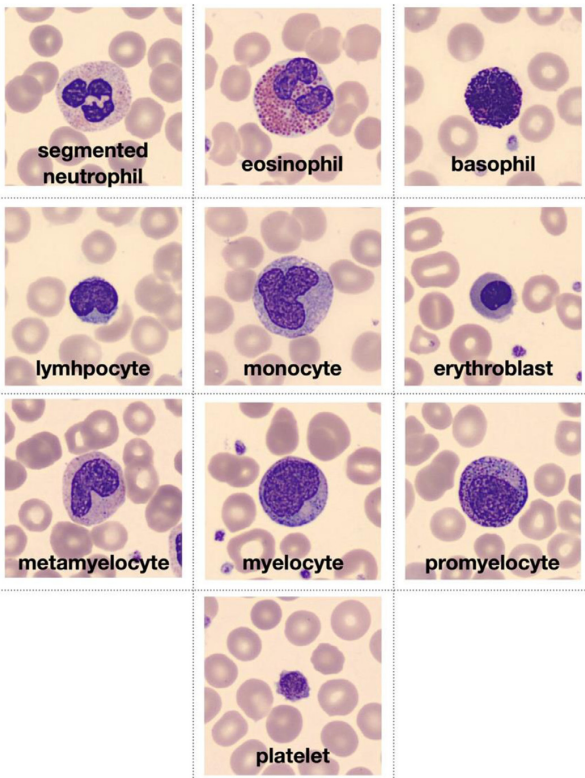

**Dataset Information:**

- You should respect the following training/validation/test split. Avoid overfitting.
- The data is available at Google Classroom or at https://drive.google.com/file/d/1DPGlDIRp_kGqhHyUAlkL7OH8RVbkRRbi/view?usp=sharing
- You should evaluate the models using **balanced accuracy** or **AUC**.

## Deadline
Friday, October 21 11:59pm.

Penalty policy for late submission: You are not encouraged to submit your assignment after due date. However, in case you do, your grade will be penalized as follows:
- October 22 11:59pm : grade * 0.75
- October 23 11:59pm : grade * 0.5
- October 24 11:59pm : grade * 0.25


## Submission

On Google Classroom, submit your Jupyter Notebook (in Portuguese or English).

**This activity is NOT individual, it must be done in pairs (two-people group).**

In [ ]:
from typing import List
from abc import ABC,abstractmethod
from torch.utils.data import Dataset, DataLoader
import torch

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [ ]:
# prepare data to use with Pytorch Dataloader

class BloodMNIST(Dataset):
    def __init__(self, x, y=None, transform=None):
        self._x = x
        self._y = y.squeeze() if y is not None else None
        self._transform = transform

    def __len__(self):
        return self._x.shape[0]

    def __getitem__(self, idx):
        image = self._x[idx]
        if self._transform is not None:
            image = self._transform(image)

        image = image.flatten()
        if self._y is None:
            return image

        # one hot encoding
        label = [0] * 8
        label[self._y[idx]] = 1
        return image, torch.Tensor(label)

In [ ]:
# an example of normalization function, but you can implement others
def normalize(X):
    return (X - X.mean())/(X.std() + 1e-8)

#### Loading data

In [ ]:
# set the dataset path correctly
dataset_path = 'bloodmnist.npz'
bloodmnist = np.load(dataset_path)

x_train, y_train = bloodmnist['train_images'], bloodmnist['train_labels']
x_val, y_val = bloodmnist['val_images'], bloodmnist['val_labels']

# you do not have access to the labels of the test set
x_test = bloodmnist['test_images']


In [ ]:
train_set = BloodMNIST(x_train, y_train, transform=normalize)
val_set = BloodMNIST(x_val, y_val, transform=normalize)
test_set = BloodMNIST(x_test, transform=normalize)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)






## Implementation tasks

#### Activation & Loss Functions

Activation functions are essential components of a neural network. So, explore different activation functions in your models and analyze the differences in the results. Also, implement the cross-entropy and use it as your loss function since you are working on a multi-class classification problem.

Implement, in the indicated place, the following functions:

* Softmax (its gradient is already implemented);
* Cross-Entropy (its gradient is already implemented);
* An activation function of your preference, as well as its gradient. It must be a subclass of ``BaseFunction``. (For reference, read this [blog post](https://dwaithe.github.io/blog_20170508.html).)

In [ ]:
class BaseFunction(ABC):
    @abstractmethod
    def __call__(self, X):
        pass

    @abstractmethod
    def grad(self, X):
        pass


class ReLU(BaseFunction):
    def __call__(self, X):
        return np.maximum(np.zeros_like(X), X)

    def grad(self, X):
        return np.where(X >= 0, 1, 0)

#tanh
#(np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))  = tanh
#Função de ativação desenvolvida.
class Activation(BaseFunction):
    def __call__(self, X):
      tanh = (2 / (1 + np.exp(-2*X))) - 1
      return tanh
    def grad(self, X):
      tanh = (2 / (1 + np.exp(-2*X))) - 1
      return 1 - tanh**2



class Softmax(BaseFunction):
    def __call__(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Softmax output


        e_x = np.exp(X - np.max(X))
        # Calculando a softmax.
        for i in range(len(X)):
            e_x[i] /= np.sum(e_x[i])

        return e_x
        """
        e_x = [] #empty
        for i in range(X.shape[0]): #softmax
            count = 0
            arr = [] #array
            for j in range(X.shape[1]): #by each column of array
                arr.append((np.exp(X[i,j])) / (np.exp(X[i,:]).sum())) # e_x[i] /= np.sum(e_x[i])
            e_x.append(arr) #goal: Use softmax instead sigmoid function.
        return np.array(e_x) #softmax return


    def grad(self, X):
        return 1 # discard this gradient


class CrossEntropy(BaseFunction):
    def __call__(self, Y, Y_pred):
        """
        Arguments:
        Y: (np.array) ground-truth labels
        Y_pred: (np.array) predicted labels

        Return:
        Cross-Entropy output
        """
        n = Y.shape[0]
        cross_entropy = (-1 / n) * np.sum(Y * np.log(Y_pred + 1e-8))
        return cross_entropy

    def grad(self, Y, Y_pred):
        return Y_pred - Y # gradient with respect to Softmax's input




**Sanity Check**

In [ ]:
######## checking Softmax ########

s = Softmax()
x = np.array([[0,0],
              [1,2],
              [-3,2]])

expected_softmax = np.array([[0.5       , 0.5       ],
                             [0.26894142, 0.73105858],
                             [0.00669285, 0.99330715]])
result_softmax = s(x)
assert (abs(result_softmax - expected_softmax) < 1e-8).all(), f"Expected result for softmax is {expected_softmax}, but it returns {result_softmax}"

In [ ]:
######## checking CrossEntropy ########

Y = np.array([[0, 1, 1],
              [1, 0, 0]])

Y_pred = np.array([[0, 1, 1],
                   [0.7, 0, 0.3],])


expected_ce = 0.1783374548265092
cross_entropy = CrossEntropy()
ce_result = cross_entropy(Y, Y_pred)
assert abs(ce_result - expected_ce) < 1e-8, f"Expected result for cross entropy is {expected_ce}, but it returns {ce_result}"

expected_grad = np.array([[ 0. ,  0. ,  0. ],
                          [-0.3,  0. ,  0.3]])
grad = cross_entropy.grad(Y, Y_pred)
assert (abs(grad - expected_grad) < 1e-8).all(), f"Expected result for cross entropy gradient is {expected_grad}, but it returns {grad}"

#### Model

In a neural network, the predictions are made using an algorithm called Feedforward, also known as the forward step. Thus, you have to implement this method to make predictions using your models.

In addition, it is critical to initialize the network weights properly to ensure a better-performing model. Otherwise, it can give rise to a Vanishing Gradient or Exploding Gradient problem. So, try different weights initialization techniques and see what happens. We already implemented the random and [He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) Normal initialization for you :D

Implement, in the indicated place, the following methods:

* Feedforward, also known as the forward step;
* A weight initialization method of your choice. (For reference, read this [blog post](https://www.geeksforgeeks.org/weight-initialization-techniques-for-deep-neural-networks/).)

PS. Note that the weight matrices $W$ in the network are constructed so that $w^{l}_{i,j}$ is the weight that connects the i-th neuron in the l-th layer to the j-th neuron in the following layer, as illustrated below.



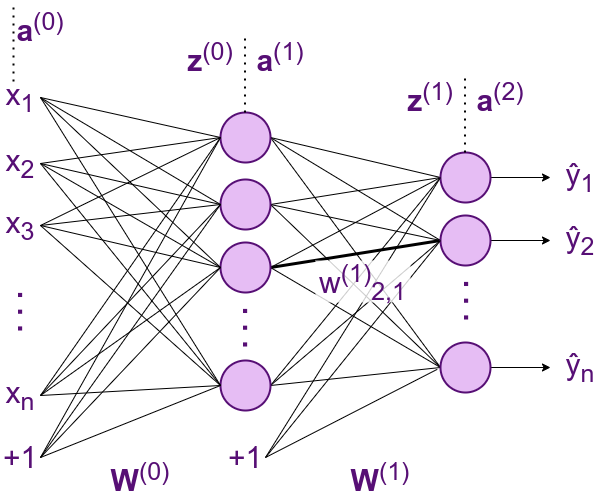


**Feed Forward**:

$a^{(l)} = f_{(l-1)}(z^{(l-1)})$

In [ ]:
class Model:
    def __init__(self, layers_dims: List[int],
                 activation_funcs: List[BaseFunction],
                 initialization_method: str = "random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        activation_funcs: (list) a list with the activation functions
        initialization_method: (str) indicates how to initialize the parameters

        Example:

        # a model architecture with layers 2 x 1 x 2 and 2 ReLU as activation functions
        >>> m = Model([2, 1, 2], [ReLU(), ReLU()])
        """

        assert all([isinstance(d, int) for d in layers_dims]), \
        "It is expected a list of int to the param ``layers_dims"

        assert all([isinstance(a, BaseFunction) for a in activation_funcs]), \
        "It is expected a list of BaseFunction to the param ``activation_funcs´´"

        self.layers_dims = layers_dims
        self.activation_funcs = activation_funcs
        self.weights, self.bias = self.initialize_model(initialization_method)


    def __len__(self):
        return len(self.weights)


    def initialize_model(self, method="random"):
        """
        Arguments:
        layers_dims: (list) a list with the size of each layer
        method: (str) indicates how to initialize the parameters

        Return: a list of matrices (np.array) of weights and a list of
        matrices (np.array) of biases.
        """

        weights = []
        bias = []
        n_layers = len(self.layers_dims)
        for l in range(0, n_layers-1):
            # the weight w_i,j  connects the i-th neuron in the current layer to
            # the j-th neuron in the next layer
            W = np.random.randn(self.layers_dims[l], self.layers_dims[l + 1])
            b = np.random.randn(1, self.layers_dims[l + 1])

            # He et al. Normal initialization
            if method.lower() == 'he':
                W = W * np.sqrt(2/self.layers_dims[l])
                b = b * np.sqrt(2/self.layers_dims[l])

            # Xavier initialization - Glorot & Bengio
            if method.lower() == 'xavier':
              W = W * np.sqrt(1/self.layers_dims[1])
              b = b * np.sqrt(1/self.layers_dims[1])


            weights.append(W)
            bias.append(b)

        return weights, bias


    def forward(self, X):
        """
        Arguments:
        X: (np.array) input data

        Return:
        Predictions for the input data (np.array)
        """
        activation = X
        self.activations = [X]
        self.Z_list = []
        #############################################################################
        # TODO: implement here the forward step.
        #
        # A few more instructions:
        # Note that the weights, bias and activation functions are class variables,
        # then you can access them via ``self``.
        #
        # You should store the input Z of each activation function in ``Z_list``,
        # and the output of the activation functions in ``activations``. These
        # information will be important when you implement the backward pass.
        #############################################################################

        for i in range(len(self.weights)):
           Z = np.matmul(activation,self.weights[i]) + self.bias[i]
           self.Z_list.append(Z)
           activation = self.activation_funcs[i](Z)
           self.activations.append(activation)
        return activation

**Sanity check**

In [ ]:
######## checking Forward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), ReLU()])

X = np.array([[0 ,1],
              [-1,0]])

W1 = np.array([[2],
               [1]])
b1 = np.array([[1]])
W2 = np.array([[2, 3]])
b2 = np.array([[1, -1]])

m.weights = [W1, W2]
m.bias = [b1, b2]

expected_prediction = np.array([[5,5],
                                [1,0]])

expected_Z_list = [np.array([[2],
                             [-1]]),
                   np.array([[5,5],
                             [1,-1]]),]

expected_activations = [X,
                        np.array([[2],
                                  [0]]),
                        expected_prediction]

#forward pass
prediction = m.forward(X)

for l, (expected_z, z) in enumerate(zip(expected_Z_list, m.Z_list)):
    assert ((z - expected_z) < 1e-8).all(), \
    f"Forward pass {l}: expected Z list is {expected_z}, but it returns {z}"

for l, (expected_a, a) in enumerate(zip(expected_activations, m.activations)):
    assert (abs(a-expected_a) < 1e-8).all(), \
    f"Forward pass {l}: expected activations are {expected_a}, but it returns {a}"

assert (abs(prediction - expected_prediction) < 1e-8).all(), \
f"Forward: expected result is {expected_prediction}, but it returns {prediction}"

**negrito**#### Optimizers

Once you have designed your neural network's topology/architecture, it is time to train it. To do so, you need to select an optimizer (e.g., SGD, Momentum, Adagrad, Adam, RMSProp) that will update the network's weights.

Implement in the indicated place:

* Stochastic Gradient Descent (SGD);
* Another optimizer of your preference. It must be a subclass of ``BaseOptimizer``. (For reference, read http://ruder.io/optimizing-gradient-descent.)

In [ ]:
class BaseOptimizer(ABC):
    def __init__(self, model):
        self.model = model

    @abstractmethod
    def step(self, grads):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        pass

class SGDOptimizer(BaseOptimizer):
    def __init__(self, model, lr=1e-3):
        self.model = model
        self.lr = lr

    def step(self, grads: List):
        """
        Arguments:
        grads: (list)  a list of tuples of matrices (weights' gradient, biases' gradient)
        both in np.array format.

        Return:
        """
        ###############################################################
        # TODO: implement Stochastic Gradient Descent (SGD) algorithm
        ##############################################################
        #weights_vector, bias_vector = zip(*grads)

        for i in range(len(self.model.weights)):
          weights_vector,bias_vector = grads[i]
          self.model.weights[i] = self.model.weights[i] - self.lr * weights_vector
          self.model.bias[i] = self.model.bias[i] - self.lr * bias_vector




### momentum
class MomentumOptimizer(BaseOptimizer):
  def __init__(self, model, lr=1e-3):
      self.model = model
      self.lr = lr
      self.momentum_w = [np.zeros(w.shape) for w in self.model.weights]
      self.momentum_b = [np.zeros(b.shape) for b in self.model.bias]




  def step(self, grads:List):
    gama = 0.9
    for i in range(len(self.model.weights)):
        weights_vector,bias_vector = grads[i]
        self.momentum_w[i] = gama *  self.momentum_w[i] + self.lr * weights_vector
        self.momentum_w[i] = gama *  self.momentum_b[i] + self.lr * bias_vector
        self.model.weights[i] = self.model.weights[i] - self.lr * self.momentum_w[i]
        self.model.bias[i] = self.model.bias[i] - self.lr * self.momentum_b[i]










**Sanity check**

The sanity check of SGD is placed after ``Trainer`` because it uses the backpropagation algorithm to compute the gradients.

#### Trainer

A weight $w_{i,j}$ of a neural network is updated based on the gradient of the loss function for $w_{i,j}$. Then, we need to compute the gradient of the loss function with respect to all the weights and biases in each layer in the network. This process is called backpropagation, a.k.a backward step.

Implement:
* Backpropagation algorithm.

> *Hint: use the following recursive equations to compute the backpropagation.*
>
> $\frac{\partial C}{\partial z^{(L-1)}} = \frac{\partial C}{\partial a^{(L)}} \cdot \frac{\partial C}{\partial z^{(L-1)}}$
>
> $\frac{\partial C}{\partial z^{(l)}} = [\frac{\partial C}{\partial z^{(l+1)}} \cdot W_{(l+1)}^T] \odot \frac{\partial f_{(l)}}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial W^{(l)}} = \frac{1}{m} \cdot a^{(l)^T} \cdot \frac{\partial C}{\partial z^{(l)}}$
>
> $\frac{\partial C}{\partial b^{(l)}} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial C}{\partial z_i^{(l)}}$
>
> Where $C$ is your cost/loss function, $m$ is the batch size,  $a^{(L)}$ is the last activation function output, $z_i^{(l)}$ is the i-th row of the matrix $z^{(l)}$, and $\odot$ is the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices))/element-wise product.

In [ ]:

class Trainer:
    def __init__(self, model, optimizer, loss_func):
        self.model = model
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.batch_size = 0

    def backward(self, Y):
        """
        Arguments:
        Y: (np.array) ground truth/label vector.

        Return:
        A list of tuples of matrices (weights' gradient, biases' gradient) both in np.array format.
        The order of this list should be the same as the model's weights.
        For example: [(dW0, db0), (dW1, db1), ... ].
        """
        ############################################################
        # TODO: implement here the backward step.
        ############################################################
        #example Y -> y = np.array([[0,1], [1,0]])

        #Need to change batch_size in __init__. use self.batch_size

        #################################################################
        # annotations
        # self.model.activation_funcs[i].grad(self.model.Z_list[i]) #example how da/dz
        #
        # dC/dz(L-1) = dC/da(L) x da(L)/dz(L-1)
        #################################################################
        dif = self.loss_func.grad(Y, self.model.activations[-1]) * self.model.activation_funcs[-1].grad(self.model.Z_list[-1])
        d_w = [np.zeros(w.shape) for w in self.model.weights]
        d_b = [np.zeros(b.shape) for b in self.model.bias]

        for i in range(len(self.model.layers_dims) - 2, -1, -1):
            d_w[i] = (1/self.batch_size) * np.dot(self.model.activations[i].T, dif)
            d_b[i] = (1/self.batch_size) * np.sum(dif, axis=0)
            if i > 0:
                dif = (dif @ self.model.weights[i].T) * self.model.activation_funcs[i - 1].grad(self.model.Z_list[i-1])

        return list(zip(d_w, d_b))




    def train(self, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader):
        """
        Arguments:
        n_epochs: (int) number of epochs
        train_loader: (DataLoader) train DataLoader
        val_loader: (DataLoader) validation DataLoader

        Return:
        A dictionary with the log of train and validation loss along the epochs
        """
        log_dict = {'epoch': [],
                   'train_loss': [],
                   'val_loss': []}

        self.batch_size = train_loader.batch_size
        for epoch in tqdm.tqdm_notebook(range(n_epochs)):
            train_loss_history = []

            for i, batch in enumerate(train_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                train_loss = self.loss_func(Y, Y_pred)
                train_loss_history.append(train_loss)

                grads = self.backward(Y)
                self.optimizer.step(grads)

            val_loss_history = []
            for i, batch in enumerate(val_loader):
                X, Y = batch
                X = X.numpy()
                Y = Y.numpy()
                Y_pred = self.model.forward(X)
                val_loss = self.loss_func(Y, Y_pred)
                val_loss_history.append(val_loss)

            # appending losses to history
            train_loss = np.array(train_loss_history).mean()
            val_loss = np.array(val_loss_history).mean()

            log_dict['epoch'].append(epoch)
            log_dict['train_loss'].append(train_loss)
            log_dict['val_loss'].append(val_loss)

        return log_dict

**Sanity check**

In [ ]:
######## checking Backward pass ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)

# We let this value just in case you need to check your results
#
# expected_dZ1 = np.array([[ 0.5       , -0.5       ],
#                         [-0.11920292,  0.11920292]])
#
# expected_dZ0 = np.array([[-0.5],
#                          [ 0. ]])
#
# y_pred = np.array([[0.5       , 0.5       ],
#                    [0.88079708, 0.11920292]])


expected_dW1 = np.array([[ 0.5, -0.5]])

expected_db1 = np.array([[ 0.19039854, -0.19039854]])

expected_dW0 = np.array([[ 0.  ],
                         [-0.25]])

expected_db0 = np.array([[-0.25]])

dW1, db1 = grads[1]
assert (abs(expected_dW1 - dW1) < 1e-8).all(), f"Expected result for dW1 is {expected_dW1}, but it returns {dW1}"
assert (abs(expected_db1 - db1) < 1e-8).all(), f"Expected result for db1 is {expected_db1}, but it returns {db1}"

dW0, db0 = grads[0]
assert (abs(expected_dW0 - dW0) < 1e-8).all(), f"Expected result for dW0 is {expected_dW0}, but it returns {dW0}"
assert (abs(expected_db0 - db0) < 1e-8).all(), f"Expected result for db0 is {expected_db0}, but it returns {db0}"

In [ ]:
######## checking SGD Optimizer ########

# architecture: 2 x 1 x 2
m = Model([2, 1, 2], [ReLU(), Softmax()])

X = np.array([[0 ,1],
              [-1,0]])

W0 = np.array([[2],
               [1]])
b0 = np.array([[1]])
W1 = np.array([[2, 3]])
b1 = np.array([[1, -1]])

m.weights = [W0, W1]
m.bias = [b0, b1]

t = Trainer(m, None, CrossEntropy())
t.batch_size = X.shape[0]

y = np.array([[0,1],
              [1,0]])
prediction = m.forward(X)
grads = t.backward(y)
opt = SGDOptimizer(m, lr=1)
opt.step(grads)

expected_W0 = np.array([[2.  ],
                        [1.25]])
expected_b0 = np.array([[1.25]])

expected_W1 = np.array([[1.5, 3.5]])
expected_b1 = np.array([[ 0.80960146, -0.80960146]])

W0, b0 = m.weights[0], m.bias[0]
assert (abs(expected_W0 - W0) < 1e-8).all(), f"Expected result for W0 after SGD update step is {expected_W0}, but it returns {W0}"
assert (abs(expected_b0 - b0) < 1e-8).all(), f"Expected result for b0 after SGD update step is {expected_b0}, but it returns {b0}"

W1, b1 = m.weights[1], m.bias[1]
assert (abs(expected_W1 - W1) < 1e-8).all(), f"Expected result for W1 after SGD update step is {expected_W1}, but it returns {W1}"
assert (abs(expected_b1 - b1) < 1e-8).all(), f"Expected result for b1 after SGD update step is {expected_b1}, but it returns {b1}"

#### Usage example

Usage example of the framework we just created.

In [ ]:
# Auxiliar function to plot loss along the epochs
def plot_history(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots()
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')

    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss along the training')
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

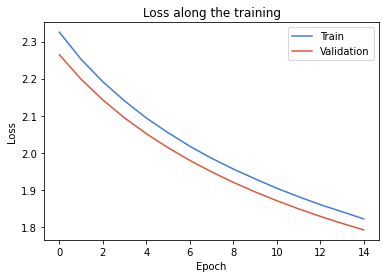

In [ ]:
model = Model([2352,500, 100, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

## Exploratory activities

For all exercises, plot the loss along the epochs and print your model's performance in the validation set.


1. (1 point) Design a Neural Network, using one or two hidden layers, ReLU and softmax as activation functions, random weight initialization, and SGD to train it. You should choose an appropriate learning rate and a number of epochs.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


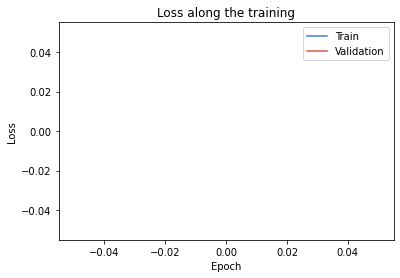

Model's performance in the validation set (last epoch): nan


In [ ]:
model = Model([2352,500, 8], [ReLU(), Softmax()], "")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

print("Model's performance in the validation set (last epoch):", history['val_loss'][-1])

> What are the conclusions? (1-2 paragraphs)


A conclusão é que ocorreu *Overflow* no modelo com inicialização aleatória. Por ser uma inicialização ruim, o modelo com inicialização aleatória acaba divergindo, culminando em um *Overflow* onde os valores de gradientes se tornaram NANs por causa da inicialização aleatória.

Uma das possibilidades para evitar o overflow é tomar no modelo algoritmos para ter uma melhor inicialização de pesos e bias, como inicialização de He e Xavier, por exemplo, onde ambas foram implementadas e serão utilizadas na próxima questão.

2. (2 points) Experiment other two weight & bias initialization techniques (He et al. Normalization, and the other one you implemented).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

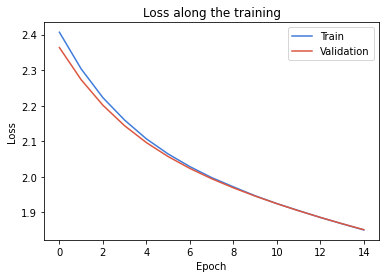

Model's performance in the validation set (last epoch): 1.8507864777423535


In [ ]:
model = Model([2352,1000, 200, 8], [ReLU(), ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

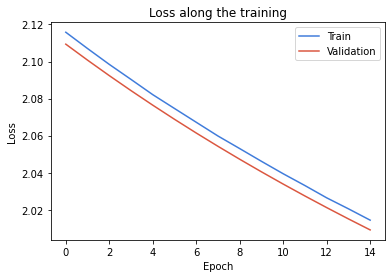

Model's performance in the validation set (last epoch): 2.0091323163923565


In [ ]:
model = Model([2352,1000, 200, 8], [ReLU(), ReLU(), Softmax()], initialization_method="xavier")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

> What are the conclusions? How do the techniques influence the performance of the models? (1-2 paragraphs)


A primeira conclusão notória sobre como as tecnicas de inicialização de pesos e bias influenciam na performance dos modelos de redes neurais é a comparação com o método de inicialização aleatória, onde utilizar os métodos de inicialização (no nosso caso foram testados o HE e o Xavier) evitou a ocorrência de *overflow* do modelo. Além disso, uma inicialização de qualidade pode ajudar as redes neurais a aprenderem de maneira mais veloz.

Foram utilizadas duas técnicas (He e Xavier) e ambas são modelos relativamente parecidos e que se baseiam na relativa igualdade da escala do gradiente entre as camadas da rede neural e com isso ambas auxiliam no treino do modelo. Nos gráficos é possível observar algumas diferenças, como uma queda mais acentuada do índice de erro na He em relação a Xavier e números iniciais e finais diferentes de erro. Por mais que sejam poucas épocas e seja um modelo mais simples (o que naturalmente afeta a análise) uma possível explicação para esse resultado é que a inicialização He costuma a lidar melhor com função de ativação ReLu do que a Xavier, enquanto para layers com ativação sigmoide o Xavier costuma a ter destaque. Como utilizamos duas camadas Relu isso poderia explicar o desenho diferente de ambas, porém a conclusão que é uma inicialização de pesos e bias pode ajudar na velocidade do treinamento das redes neurais e evitar overflow do modelo.

3. (1 point) Choose the weight & bias initialization technique that resulted in the best performance, and try the other activation function you implemented.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

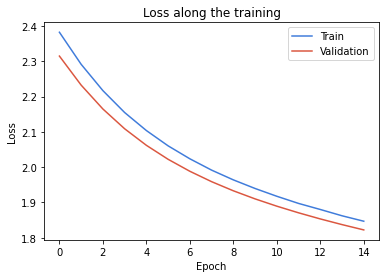

Model's performance in the validation set (last epoch) loss: 1.8221089201501064


In [ ]:
model = Model([2352,1000, 200, 8], [Activation(), Activation(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)


print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

> What are the conclusions? Does it make any difference in the results? (1-2 paragraphs)


Escolhemos a técnica de inicialização He, pois acreditamos que a velocidade de queda do valor do erro através das épocas foi muito interessante e a função de ativação criada foi a nomeada Activation(), onde a função é a função de ativação utilizada foi a Tanh.
A função de ativação Tanh é bem semelhante à função sigmóide, por ter sua saturação em grandes valores positivos ou grandes valores negativos, além de seu gradiente desaparecer na saturação. A sua variação é de -1 a 1, tem como característica também a sua média centrada em zero, isso ocorre para que não haja certa restrição de movimento dos gradientes para diferentes direções.
Em nosso modelo ela se mostrou adequada, dado que foi possível ver uma queda no erro com o passar das épocas e o modelo não sofreu com problemas como problema de overflow e outros. Inclusive foi observado que o modelo com a função de ativação criada com a mesma inicialização teve resultados tão bons quanto a função de ativação ReLu para o mesmo número de épocas, sendo assim uma função de ativação adequada.

4. (3 points) Explore different network architectures, varying the number of layers and the number of neurons in each layer. It is an empirical experiment.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/30 [00:00<?, ?it/s]

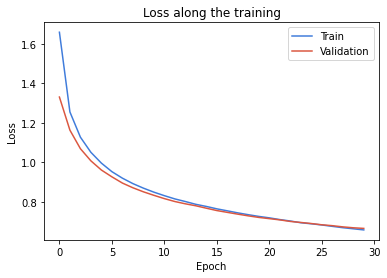

Model's performance in the validation set (last epoch) loss: 0.6667743013990759


In [ ]:
model = Model([2352, 200, 8], [ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(30, train_loader, val_loader)
plot_history(history)


print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

Observando como o número de iterações,  número de layers impacta no modelo e o learning rate impactam no treinamento do modelo (lr aumentado em 100 vezes).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

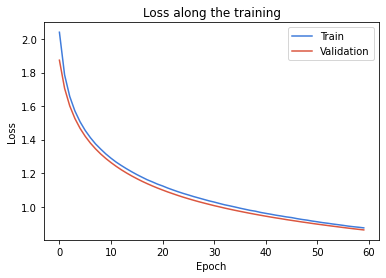

Model's performance in the validation set (last epoch) loss: 0.8617775635602984


In [ ]:
model = Model([2352, 1000, 200, 8], [ReLU(), ReLU(),Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(60, train_loader, val_loader)
plot_history(history)

print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

Observando como o número de iterações e um maior número de layers impacta no modelo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

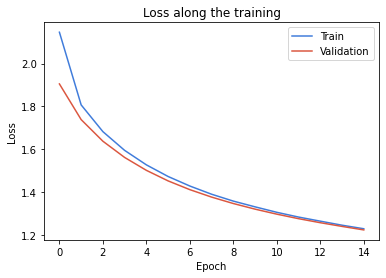

Model's performance in the validation set (last epoch) loss: 1.2228209713982965


In [ ]:
model = Model([2352, 200, 8], [ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)

print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

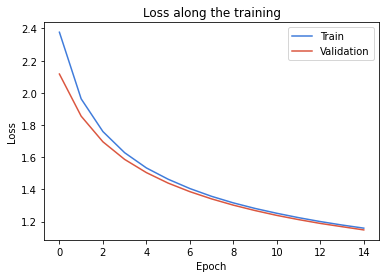

Model's performance in the validation set (last epoch) loss: 1.1484676253999515


In [ ]:
model = Model([2352, 800, 200, 8], [ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

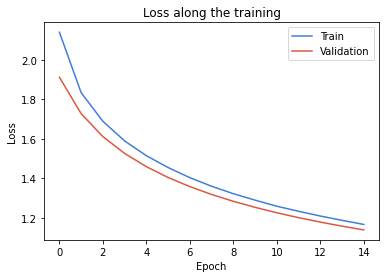

Model's performance in the validation set (last epoch) loss: 1.140043379428881


In [ ]:
model = Model([2352, 800, 500, 200, 8], [ReLU(),ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

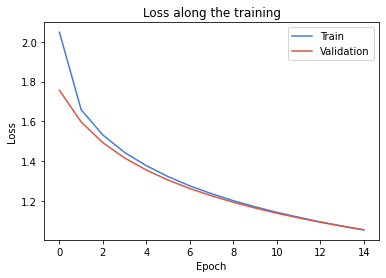

Model's performance in the validation set (last epoch) loss: 1.0546527207663445


In [ ]:
model = Model([2352, 1500, 1200, 800, 500, 150, 8], [ReLU(),ReLU(),ReLU(),ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(15, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

> What are the conclusions? How does the number of layers impact the performance of the models? (2-4 paragraphs)


No teste empírico foi interessante ver o impacto do número de layers e até mesmo o impacto de cada arquitetura no treinamento do modelo, observando o impacto do learning rate e das funções de ativação dos layers.

Falando especificamente do número layers no impacto da performance é importante lembrar que a estrutura de uma rede neural é composta de uma camada de entrada, uma camada de saída e entre elas uma camada oculta, onde é possível ter uma ou mais camadas ocultas na rede. Logo de cara é possível perceber uma correlação entre o número de camadas ocultas e o tempo de treinamento da rede: Quanto maior o número de Layers, maior o tempo de treinamento. É claro que esse tempo pode variar dependendo de como é a arquitetura da rede, porém para o nosso caso ficou claro que alterando apenas o número de camadas foi necessário mais tempo para treinar na medida em que o número de layers aumentavam.

Um modelo com mais camadas também tende a retornar um erro menor para uma taxa de aprendizado, épocas e otimizadores fíxos. Nas últimas 4 configurações foram criados 4 configurações que só tinham como diferente o número de camadas ocultas e foi possível observar que a performance no conjunto de validação foi melhorando na medida em que foram adicionadas mais camadas. Porém vale ressaltar que o tempo de treinamento aumentou bastante e na medida em que o número de camadas aumentava a diferença de desempenho era cada vez menor.

Assim é possível observar que há um tradeoff entre tempo de treinamento e o desempenho da rede neural, cabendo ao desenvolvedor analisar diferentes variávies além do número de camadas como learning rate, funções de ativação e número de épocas para observar o melhor modelo de custo benefício. A conclusão é que o ideal é levar em conta mais coisas além de número de camadas. É possível optar por modelos com menos camadas e alterando outros parâmetros alcançar resultados adequados e tentar compensar a perda de performance na velocidade do treinamento.   



5. (2 points) Pick the best network architecture and train your model using the optimizer you chose to implement.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

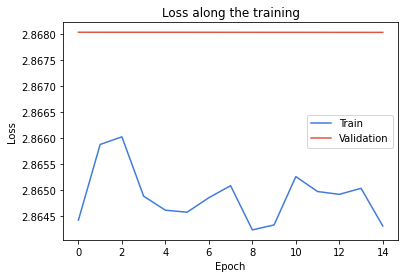

In [ ]:
model = Model([2352, 1800, 900, 200, 8], [ReLU(),ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = MomentumOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20 [00:00<?, ?it/s]

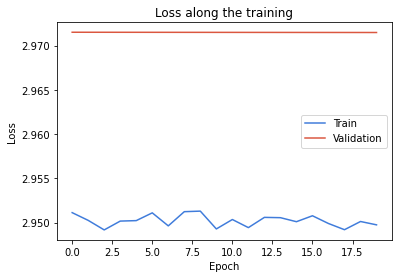

Model's performance in the validation set (last epoch) loss: 2.971479891232753


In [ ]:
model = Model([2352, 1800, 900, 200, 8], [ReLU(),ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = MomentumOptimizer(model, lr=1e-5)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(20, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

> What are the conclusions? Does the change of optimizer anyhow impact the loss curve over the epochs? (1-2 paragraphs)


Observando os resultados obtidos com o método de otimização Momentum, é possível observar através do terceiro gráfico da questão 4, em que o otimizador utilizado foi o SGD, se teve um comportamento muito melhor do modelo para o mesmo número de camadas e épocas. O que pode destacar que o SGD pode ser mais vantajoso para certas métricas do que o Momentum.
Mesmo alterando a quantidade de épocas e camadas de ativação, o modelo teve uma piora em seu desempenho com o otimizador Momentum. O que evidencia que o SGD pode ser melhor aplicável do que o Momentum na medida em que converge o resultado para o mínimo de maneira mais eficiente.


6. (1 point) Pick your **best model**, make predictions to the test set and submit them to the Kaggle competition [3rd ML Assignment](https://www.kaggle.com/t/cbf42d49ae514153bd4d04e0a69d684f). Print your score considering the public leaderboard.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/60 [00:00<?, ?it/s]

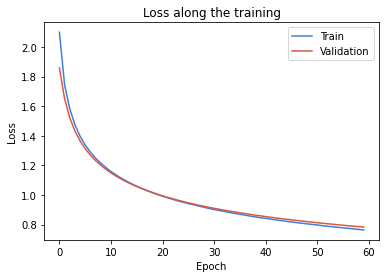

Model's performance in the validation set (last epoch) loss: 0.783419508576844


In [ ]:
model = Model([2352, 1800, 900, 200, 8], [ReLU(),ReLU(),ReLU(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-4)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(60, train_loader, val_loader)
plot_history(history)
print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

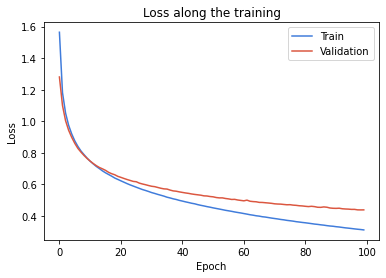

Model's performance in the validation set (last epoch) loss: 0.4386607574468024


In [ ]:
model = Model([2352, 1600, 800, 8], [ReLU(), Activation(), Softmax()], initialization_method="he")
opt = SGDOptimizer(model, lr=1e-3)
trainer = Trainer(model, opt, CrossEntropy())
history = trainer.train(100, train_loader, val_loader)
plot_history(history)


print("Model's performance in the validation set (last epoch) loss:", history['val_loss'][-1])

In [ ]:
import pandas as pd

predictions = []
for i, batch in enumerate(test_loader):
    preds = trainer.model.forward(batch)
    preds = np.argmax(preds, axis=1)
    preds = preds.tolist()
    predictions = predictions + preds

df = pd.DataFrame(dict(index=np.linspace(0,len(predictions)-1,len(predictions), dtype=np.int32),
                       cell_type=np.array(predictions)))
df.to_csv('/content/df.csv', index=False)

> What are the conclusions? (1-2 paragraphs)

O modelo foi entregue no Kaggle e a primeira submissão teve score referente a 0.64856, mostrando que o modelo ainda pode ser melhorado e outras opções devem ser exploradas.

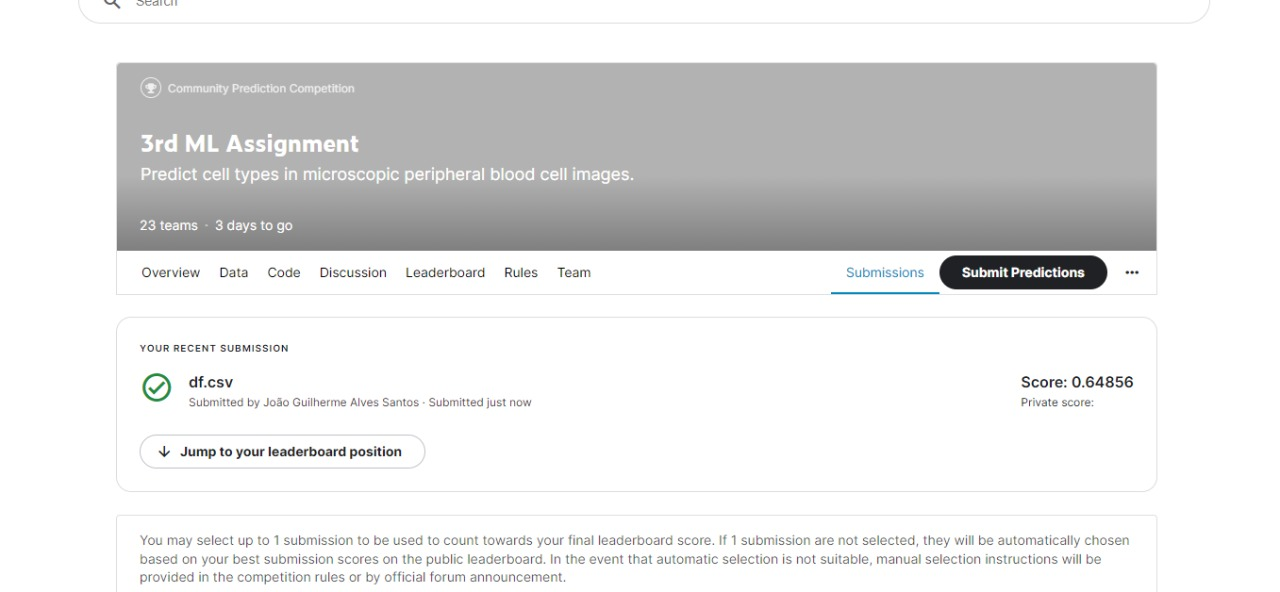

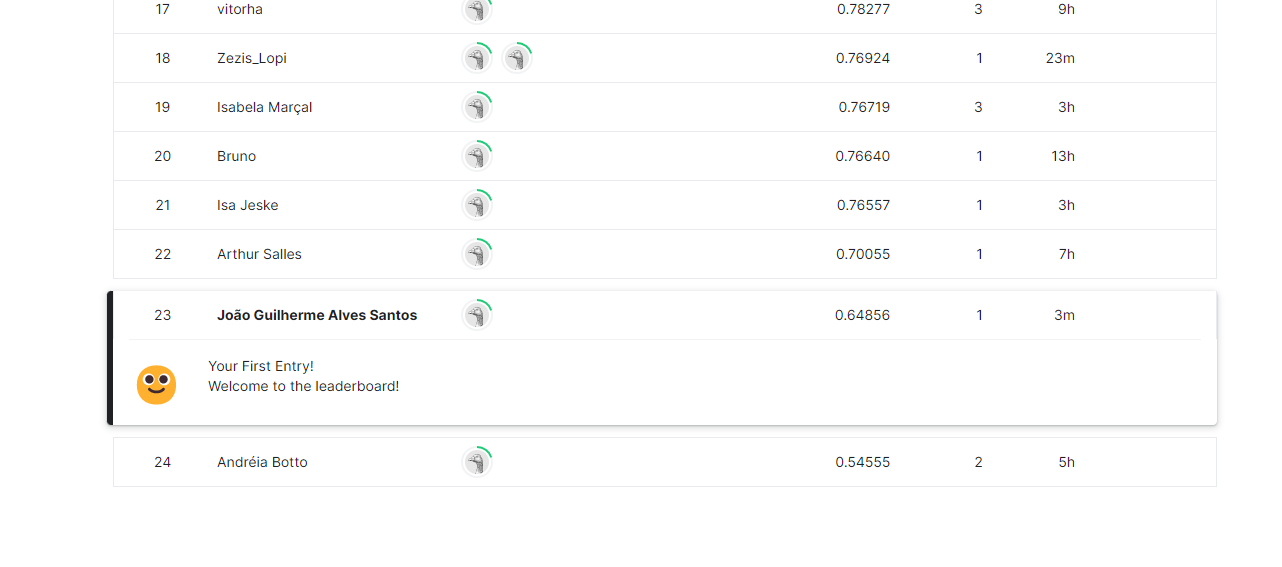